# Continuous Control

---

This notebook contains the solution for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program using UnityML environment. Specifically, we will be working with the Reacher environment, where the aim is to train an agent to reach a spot moving in space.

### 1. Starting the Environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np

from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import random
import time
import torch
from tqdm import tqdm_notebook

Starting up the Unity environment

In [3]:
env = UnityEnvironment(file_name='../Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Training

We define the training function that takes an agent as input and trains it for `n_episodes` times or until the target score is reached.

In [6]:
def ddpg(agent, n_episodes=500, max_timesteps=1000, target_score=30.0, window_size=100, print_every=1, train_mode=True,
        agent_tag = ''):
    """
        n_episodes: Max number of episodes
        max_timesteps: Max number of timesteps per episode
        target_score: min avg score over consecutive episodes
        window_size: Number of episodes for calulating average score
        print_every: Episodes interval to print results
        train_mode: Whether started in training mode or not
        agent_tag: A string to name the agent checkpoint file

    """
    
    scores_deque = deque(maxlen=window_size) 
    scores_arr = []
    
    progress = tqdm_notebook(range(1, n_episodes+1))
    
    for i_episode in progress:
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()
        start_time = time.time()
        for t in range(max_timesteps):
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):
                break

        duration = time.time() - start_time
        
        scores_deque.append(scores)
        scores_arr.append(scores)
                
        if i_episode == 1 or i_episode % print_every == 0:
            print('\rEpisode %d: \tCurrent score: %0.2f \tAverage score: %0.2f' %\
                  (i_episode, np.mean(scores), np.mean(scores_deque)))
                  
        if np.mean(scores_deque) >= target_score and i_episode >= window_size:
            print('\nTraining completed in %d episodes with average score of %0.2f' % (i_episode, np.mean(scores_deque)))
            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), './models/actor_%s.ckpt' % agent_tag)
                torch.save(agent.critic_local.state_dict(), './models/critic_%s.ckpt' % agent_tag)
            
            break
    
        progress.set_description(str(round(np.mean(scores_deque), 2)))
            
    return scores_arr

Let's find out first how the training goes with a relatively small network

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, 
              actor_units = [64, 64], critic_units=[64, 64, 64])
scores_small_net = ddpg(agent, print_every=10, agent_tag = 'small')

C:\Users\rinat.maksutov\.conda\envs\drlnd\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Episode 1: 	Current score: 0.00 	Average score: 0.00
Episode 10: 	Current score: 1.17 	Average score: 0.92
Episode 20: 	Current score: 0.35 	Average score: 0.74
Episode 30: 	Current score: 1.60 	Average score: 1.02
Episode 40: 	Current score: 0.97 	Average score: 1.32
Episode 50: 	Current score: 1.68 	Average score: 1.56
Episode 60: 	Current score: 2.98 	Average score: 1.75
Episode 70: 	Current score: 6.88 	Average score: 1.88
Episode 80: 	Current score: 3.97 	Average score: 2.09
Episode 90: 	Current score: 2.87 	Average score: 2.17
Episode 100: 	Current score: 3.34 	Average score: 2.35
Episode 110: 	Current score: 3.74 	Average score: 2.59
Episode 120: 	Current score: 5.81 	Average score: 2.97
Episode 130: 	Current score: 2.29 	Average score: 3.23
Episode 140: 	Current score: 3.61 	Average score: 3.45
Episode 150: 	Current score: 4.58 	Average score: 3.63
Episode 160: 	Current score: 3.22 	Average score: 3.67
Episode 170: 	Current score: 2.78 	Average score: 3.89
Episode 180: 	Current

Now let's check what happens if we increase the width of the network

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, 
              actor_units = [128, 128], critic_units=[128, 128, 128])
scores_med_net = ddpg(agent, print_every=10, agent_tag = 'med')

C:\Users\rinat.maksutov\.conda\envs\drlnd\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Episode 1: 	Current score: 0.57 	Average score: 0.57
Episode 10: 	Current score: 0.55 	Average score: 0.22
Episode 20: 	Current score: 0.44 	Average score: 0.57
Episode 30: 	Current score: 1.24 	Average score: 0.84
Episode 40: 	Current score: 1.33 	Average score: 0.93
Episode 50: 	Current score: 2.44 	Average score: 1.11
Episode 60: 	Current score: 4.08 	Average score: 1.37
Episode 70: 	Current score: 8.17 	Average score: 1.82
Episode 80: 	Current score: 8.27 	Average score: 2.37
Episode 90: 	Current score: 10.32 	Average score: 2.97
Episode 100: 	Current score: 5.26 	Average score: 3.41
Episode 110: 	Current score: 16.21 	Average score: 4.32
Episode 120: 	Current score: 10.03 	Average score: 5.17
Episode 130: 	Current score: 22.85 	Average score: 6.18
Episode 140: 	Current score: 10.27 	Average score: 7.63
Episode 150: 	Current score: 26.43 	Average score: 9.32
Episode 160: 	Current score: 21.50 	Average score: 10.90
Episode 170: 	Current score: 30.57 	Average score: 12.73
Episode 180

And now even bigger network!

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, 
              actor_units = [256, 256], critic_units=[256, 256, 128])
scores_large_net = ddpg(agent, print_every=10, agent_tag = 'large')

C:\Users\rinat.maksutov\.conda\envs\drlnd\lib\site-packages\ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Episode 1: 	Current score: 0.72 	Average score: 0.72
Episode 10: 	Current score: 1.62 	Average score: 0.76
Episode 20: 	Current score: 0.30 	Average score: 0.79
Episode 30: 	Current score: 3.47 	Average score: 1.34
Episode 40: 	Current score: 5.29 	Average score: 1.81
Episode 50: 	Current score: 4.58 	Average score: 2.17
Episode 60: 	Current score: 5.08 	Average score: 2.64
Episode 70: 	Current score: 8.85 	Average score: 3.23
Episode 80: 	Current score: 7.60 	Average score: 3.97
Episode 90: 	Current score: 8.06 	Average score: 4.56
Episode 100: 	Current score: 15.77 	Average score: 5.33
Episode 110: 	Current score: 11.65 	Average score: 6.72
Episode 120: 	Current score: 16.05 	Average score: 8.04
Episode 130: 	Current score: 21.79 	Average score: 9.39
Episode 140: 	Current score: 14.59 	Average score: 11.04
Episode 150: 	Current score: 20.50 	Average score: 12.79
Episode 160: 	Current score: 24.08 	Average score: 14.41
Episode 170: 	Current score: 27.14 	Average score: 16.13
Episode 1

Let's compare the training process for the three agents

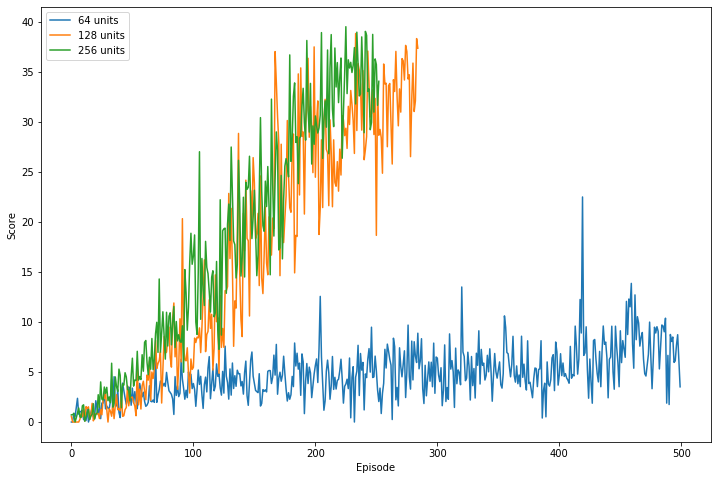

In [11]:
fig = plt.figure(figsize=(12,8))
plt.plot(np.arange(len(scores_small_net)), scores_small_net, label='64 units')
plt.plot(np.arange(len(scores_med_net)), scores_med_net, label='128 units')
plt.plot(np.arange(len(scores_large_net)), scores_large_net, label='256 units')

plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend(loc='upper left');
plt.savefig('training.png')

In [12]:
env.close()